# Lab Assignment 8

## Austin Booth

Link:

### Exercise 1
(Assuming "delay the ramp by 100 seconds" is in reference to the existing ramp, so SP2 ramp begins at t=150 s)

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp

# construct matrices based on Lab 5 results

# define parameters from Lab 2
CpH = 8.7738
CpS = 2.9110
Ua = 0.0495195
Ub = 0.273355
Uc = 0.0387042

# constant parameters
P1 = 200               # P1 units
P2 = 100               # P2 units
alpha = 0.00016        # watts / (units P1 * percent U1)

# construct arrays
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH], [0, 0, Ub/CpS, -Ub/CpS]])  # 4x4
Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])     # 4x2
Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])           # 4x1
C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])                   # 2x4

# print arrays
print('A:')
print(A)
print('Bu:')
print(Bu)
print('Bd:')
print(Bd)
print('C:')
print(C)

A:
[[-0.04121119  0.03115583  0.00441134  0.        ]
 [ 0.09390416 -0.09390416  0.          0.        ]
 [ 0.00441134  0.         -0.04121119  0.03115583]
 [ 0.          0.          0.09390416 -0.09390416]]
Bu:
[[0.00364722 0.        ]
 [0.         0.        ]
 [0.         0.00182361]
 [0.         0.        ]]
Bd:
[[0.00564402]
 [0.        ]
 [0.00564402]
 [0.        ]]
C:
[[0 1 0 0]
 [0 0 0 1]]


In [53]:
# set ambient temperature and initialize disturbance variable
from tclab import TCLab, setup, clock, Historian, Plotter

with TCLab() as lab:
    T1 = lab.T1
    T2 = lab.T2
    Tamb = (T1 + T2) / 2
    print('T_amb:', Tamb)

def d(t):
    return np.interp(t, [0, 800], [Tamb, Tamb])

TCLab version 0.4.9
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
T_amb: 26.651000000000003
TCLab disconnected successfully.


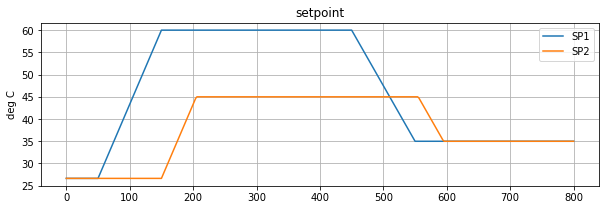

In [54]:
# time grid
tf = 800
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, tf, n+1)

# setpoint/reference
def SP1(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])

def SP2(t):
    return np.interp(t, [0, 150, 150+(100/(60-Tamb) * (45-Tamb)), 555, 595], [Tamb, Tamb, 45, 45, 35])

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, SP1(t_grid), label="SP1") 
ax.plot(t_grid, SP2(t_grid), label = "SP2")
ax.set_title('setpoint')
ax.set_ylabel('deg C')
ax.legend()
ax.grid(True)

## Exercise 2

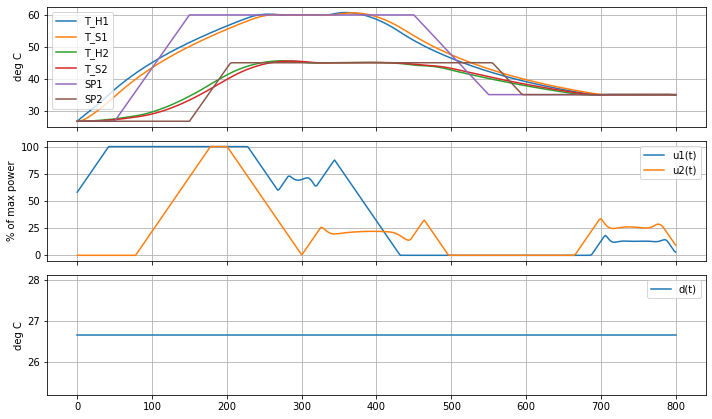

In [55]:
# add u as a decision variable
u = {t: cp.Variable(2, nonneg=True) for t in t_grid}
x = {t: cp.Variable(4) for t in t_grid}
y = {t: cp.Variable(2) for t in t_grid}

# least-squares optimization objective
objective1 = cp.Minimize(sum((y[t][0]-SP1(t))**2 for t in t_grid))
objective2 = cp.Minimize(sum((y[t][1]-SP2(t))**2 for t in t_grid))

model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[d(t-dt)]) for t in t_grid[1:]]
output = [y[t] == C@x[t] for t in t_grid]
input1 = [u[t][0] <= 100 for t in t_grid]
input2 = [u[t][1] <= 100 for t in t_grid]
IC = [x[0] == np.array([Tamb, Tamb, Tamb, Tamb])]
rate = [cp.abs(u[t] - u[t-dt]) <= dt*1 for t in t_grid[1:]]

problem = cp.Problem(objective1 + objective2,  model + IC + output + input1 + input2 + rate)
problem.solve()

# create U1 and U2 functions
u1base = []
u2base = []

for t in t_grid:
    u1base.append(u[t][0].value)
    u2base.append(u[t][1].value)
    
def U1(t):
    u1new = np.interp(t, t_grid, u1base)
    return u1new

def U2(t):
    u2new = np.interp(t, t_grid, u2base)
    return u2new

# display solution
fix, ax = plt.subplots(3, 1, figsize=(10,6), sharex=True)
ax[0].plot(t_grid, [x[t][0].value  for t in t_grid], label="T_H1")
ax[0].plot(t_grid, [x[t][1].value  for t in t_grid], label="T_S1")
ax[0].plot(t_grid, [x[t][2].value  for t in t_grid], label="T_H2")
ax[0].plot(t_grid, [x[t][3].value  for t in t_grid], label="T_S2")

ax[0].plot(t_grid, [SP1(t) for t in t_grid], label="SP1")
ax[0].plot(t_grid, [SP2(t) for t in t_grid], label="SP2")
ax[0].set_ylabel("deg C")
ax[0].legend('right')
ax[1].plot(t_grid, [U1(t) for t in t_grid], label="u1(t)")
ax[1].plot(t_grid, [U2(t) for t in t_grid], label="u2(t)")

ax[1].set_ylabel("% of max power")
ax[2].plot(t_grid, [d(t) for t in t_grid], label="d(t)")
ax[2].set_ylabel("deg C")
for a in ax:
    a.grid(True)
    a.legend()
plt.tight_layout()

## Exercise 3

In [56]:
def experiment(U1, U2, SP1, SP2, t_final=800, t_step=2):
    
    with TCLab() as lab:
        
        # setup historian and plotter
        sources = lab.sources
        sources.append(['SP1', lambda: SP1(t)]) 
        sources.append(['SP2', lambda: SP2(t)])
        h = Historian(sources)
        
        layout = [['T1', 'SP1'], ['T2', 'SP2'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
        
        # initialize event loop
        lab.Q1(0)
        lab.Q2(0)

        for t in clock(t_final, t_step):
            
            # set input for next period
            lab.Q1(U1(t))
            lab.Q2(U2(t))
            
            # update plotter and historian
            p.update(t)
            
        print('Steady-state T1:',lab.T1,'C')
        print('Steady-state T2:',lab.T2,'C')

            
    return h

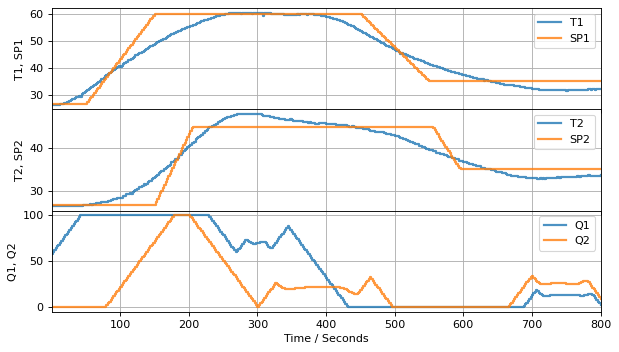

Steady-state T1: 32.081 C
Steady-state T2: 33.531 C
TCLab disconnected successfully.


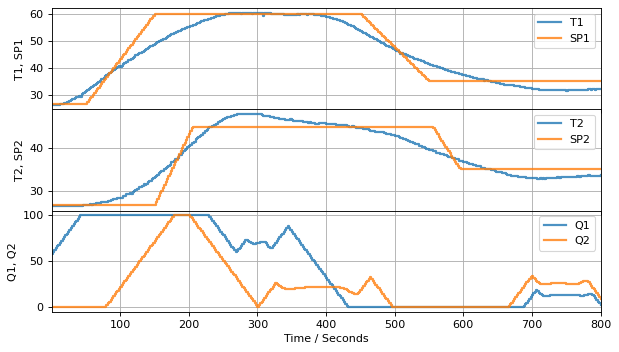

In [57]:
experiment(U1, U2, SP1, SP2)

A major issue in the feedforward control response is that the heaters could not heat or cool at the ramp rates required by the reference trajectory. Given this limitation, the control strategy worked reasonably well at minimizing deviation from setpoints with unfortunately low ramp rates. However, there was some additional deviation from SP2 around 250 seconds; an overshoot likely occurred due to combined action of both heaters. Also, the actual sensor temperatures deviated from the setpoint by a couple degrees C at the final temperature. Deviation seemed to increase over the course of the experiment, which could indicate inaccuracies in the state-space model.